In [ ]:
import pandas as pd
import pathlib
import ast
import numpy as np
import math
from collections import defaultdict
from typing import List, Dict, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns


BASE_DIR = pathlib.Path.cwd().parent.resolve()
FEATURES_DIR = BASE_DIR / 'data' / 'extraccion_caracteristicas'
OUTPUT_DIR = BASE_DIR / 'data' / 'ponderacion_caracteristicas'


OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

In [ ]:
class FeatureWeightingAnalyzer:
    
    def __init__(self, features_path: pathlib.Path):
        self.features_path = features_path
        self.dataset = None
        self.vocabulary = None
        self.document_frequencies = None
        self.tfidf_matrix = None
        
    def load_dataset(self) -> pd.DataFrame:
        try:
            self.dataset = pd.read_csv(self.features_path)
            return self.dataset
        except FileNotFoundError:
            print(f"Error: Features file not found at {self.features_path}")
            return None
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None
    
    def display_dataset_info(self):
        if self.dataset is not None:
            print(f"Dataset shape: {self.dataset.shape}")
            print(f"Columns: {list(self.dataset.columns)}")
            return self.dataset.head()
        return None
    
    def get_frequency_column_name(self) -> str:
        """Identify the correct frequency column name"""
        if self.dataset is None:
            return None
            
        possible_names = ['vocab_tfidf', 'vocab_filtrado', 'frecuencia<3', 'frecuencias', 'frequency', 'freq_data', 'term_freq']
        
        for col_name in possible_names:
            if col_name in self.dataset.columns:
                return col_name
        
        for col_name in self.dataset.columns:
            if 'vocab' in col_name.lower() or 'freq' in col_name.lower():
                return col_name
        
        return None

analyzer = FeatureWeightingAnalyzer(FEATURES_DIR / 'extraccion_caracteristicas.csv')
dataset = analyzer.load_dataset()

if dataset is not None:
    sample_data = analyzer.display_dataset_info()
    print(f"\nSample data:")
    if sample_data is not None:
        display(sample_data)

Dataset shape: (5518, 7)
Columns: ['text', 'label', 'texto_procesado', 'vocab_basico', 'vocab_sin_stopwords', 'vocab_filtrado', 'vocab_tfidf']

Sample data:


,text,label,texto_procesado,vocab_basico,vocab_sin_stopwords,vocab_filtrado,vocab_tfidf
0,distintas desinformaciones senalan falsamente ...,False,distint desinform senal fals la estatu com si ...,1000,800,600,500
1,el metraje realmente corresponde a embarcacion...,False,el metraj realment correspond embarc zarp tras...,1000,800,600,500
2,una cuenta desinformadora de derecha adelanta ...,False,una cuent desinform de derech adelant dat fals...,1000,800,600,500
3,se trata de una suplantacion que no ha sido pu...,False,se trat de una suplant que no ha sid public po...,1000,800,600,500
4,un video viral atribuye a hugo “el pollo” carv...,False,un vide viral atribu hug el poll carvajal fals...,1000,800,600,500


# Análisis de Ponderación de Características

Este notebook implementa técnicas de ponderación de características incluyendo:
- **Análisis de Frecuencia Absoluta**: Cálculos de frecuencia de términos sin procesar
- **Ponderación TF-IDF**: Puntuación de Frecuencia de Términos-Frecuencia Inversa de Documentos
- **Análisis Estadístico**: Análisis de distribución de pesos de características

## Ponderación de Características TF-IDF

Implementación del esquema de ponderación de Frecuencia de Términos-Frecuencia Inversa de Documentos para el cálculo de importancia de características.

In [ ]:
class TFIDFProcessor:
    
    def __init__(self):
        self.vocabulary = set()
        self.document_frequencies = defaultdict(int)
        self.term_documents = []
        self.documents_text = []
    
    def process_text_data(self, text_column: pd.Series) -> List[Dict[str, int]]:
        processed_documents = []
        
        
        for idx, text in text_column.items():
            if pd.isna(text) or not isinstance(text, str):
                processed_documents.append({})
                continue
            

            terms = text.strip().split()
            term_freq = defaultdict(int)
            
            for term in terms:
                if term:  
                    term_freq[term] += 1
            
            doc_dict = dict(term_freq)
            processed_documents.append(doc_dict)
            
            if doc_dict: 
                self.vocabulary.update(doc_dict.keys())
                for term in doc_dict.keys():
                    self.document_frequencies[term] += 1
        
        self.vocabulary = sorted(list(self.vocabulary))
        self.term_documents = processed_documents
        
        successful_docs = len([doc for doc in processed_documents if doc])
        print(f"Successfully processed {successful_docs} documents")
        print(f"Total vocabulary size: {len(self.vocabulary):,}")
        
        return processed_documents
    
    def calculate_tfidf_matrix(self) -> List[Dict[str, float]]:
        if not self.term_documents:

            return []
        
        num_documents = len([doc for doc in self.term_documents if doc])
        if num_documents == 0:
            return []
            
        print(f"Calculating TF-IDF for {num_documents} valid documents...")
        tfidf_matrix = []
        
        for doc_terms in self.term_documents:
            if not doc_terms:  
                tfidf_matrix.append({})
                continue
                
            doc_total_words = sum(doc_terms.values())
            doc_tfidf = {}
            
            for term, frequency in doc_terms.items():

                tf = frequency / doc_total_words if doc_total_words > 0 else 0
                

                df = self.document_frequencies[term]
                idf = math.log(num_documents / df) if df > 0 else 0
                
                tfidf = tf * idf
                doc_tfidf[term] = tfidf
            
            tfidf_matrix.append(doc_tfidf)
        
        return tfidf_matrix
    
    def get_vocabulary_statistics(self) -> Dict[str, int]:

        term_doc_counts = {}
        term_total_freq = defaultdict(int)
        
        for doc_terms in self.term_documents:
            for term, freq in doc_terms.items():
                term_total_freq[term] += freq
        
        return {
            'vocabulary_size': len(self.vocabulary),
            'total_documents': len(self.term_documents),
            'valid_documents': len([doc for doc in self.term_documents if doc]),
            'avg_terms_per_doc': np.mean([len(doc) for doc in self.term_documents if doc]),
            'max_term_frequency': max(term_total_freq.values()) if term_total_freq else 0,
            'min_term_frequency': min(term_total_freq.values()) if term_total_freq else 0
        }


if dataset is not None and 'texto_procesado' in dataset.columns:
    
    tfidf_processor = TFIDFProcessor()
    frequency_documents = tfidf_processor.process_text_data(dataset['texto_procesado'])
    tfidf_matrix = tfidf_processor.calculate_tfidf_matrix()
    
    # Get vocabulary statistics
    vocab_stats = tfidf_processor.get_vocabulary_statistics()
    print(f"\nVocabulary Statistics:")
    print("-" * 25)
    for stat_name, value in vocab_stats.items():
        if isinstance(value, float):
            print(f"{stat_name.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"{stat_name.replace('_', ' ').title()}: {value:,}")
    
    
    tfidf_calc = tfidf_processor 
    


Using 'texto_procesado' column for TF-IDF calculation...
Successfully processed 5518 documents
Total vocabulary size: 22,363
Calculating TF-IDF for 5518 valid documents...
Successfully processed 5518 documents
Total vocabulary size: 22,363
Calculating TF-IDF for 5518 valid documents...

Vocabulary Statistics:
-------------------------
Vocabulary Size: 22,363
Total Documents: 5,518
Valid Documents: 5,518
Avg Terms Per Doc: 86.80
Max Term Frequency: 67,353
Min Term Frequency: 1

Vocabulary Statistics:
-------------------------
Vocabulary Size: 22,363
Total Documents: 5,518
Valid Documents: 5,518
Avg Terms Per Doc: 86.80
Max Term Frequency: 67,353
Min Term Frequency: 1


In [36]:
class TFIDFAnalyzer:
    
    def __init__(self, tfidf_matrix: List[Dict[str, float]]):
        self.tfidf_matrix = tfidf_matrix
        self.term_statistics = {}
        self._calculate_statistics()
    
    def _calculate_statistics(self):
        term_values = defaultdict(list)
        
        for doc_tfidf in self.tfidf_matrix:
            for term, tfidf_value in doc_tfidf.items():
                term_values[term].append(tfidf_value)
        
        for term, values in term_values.items():
            self.term_statistics[term] = {
                'mean': np.mean(values),
                'max': np.max(values),
                'min': np.min(values),
                'std': np.std(values),
                'document_count': len(values)
            }
    
    def get_top_terms_by_metric(self, metric: str = 'mean', top_n: int = 10) -> List[Tuple[str, Dict]]:
        if metric not in ['mean', 'max', 'min', 'std', 'document_count']:
            raise ValueError(f"Invalid metric: {metric}")
        
        sorted_terms = sorted(
            self.term_statistics.items(),
            key=lambda x: x[1][metric],
            reverse=True
        )
        
        return sorted_terms[:top_n]
    
    def get_summary_statistics(self) -> Dict[str, float]:
        all_values = []
        for doc_tfidf in self.tfidf_matrix:
            all_values.extend(doc_tfidf.values())
        
        if all_values:
            return {
                'total_entries': len(all_values),
                'mean_tfidf': np.mean(all_values),
                'max_tfidf': np.max(all_values),
                'min_tfidf': np.min(all_values),
                'std_tfidf': np.std(all_values),
                'unique_terms': len(self.term_statistics)
            }
        return {}
    
    def display_top_terms_analysis(self, top_n: int = 5):
        metrics = ['mean', 'max', 'document_count']
        
        for metric in metrics:
            top_terms = self.get_top_terms_by_metric(metric, top_n)
            metric_name = metric.replace('_', ' ').title()
            
            print(f"\nTop {top_n} terms by {metric_name}:")
            print("-" * 50)
            
            for i, (term, stats) in enumerate(top_terms, 1):
                value = stats[metric]
                docs = stats['document_count']
                print(f"{i:2d}. {term:<20} | {metric_name}: {value:.6f} | Docs: {docs:4d}")

if 'tfidf_matrix' in locals() and tfidf_matrix:
    analyzer = TFIDFAnalyzer(tfidf_matrix)
    summary_stats = analyzer.get_summary_statistics()
    
    print("TF-IDF Summary Statistics:")
    print("=" * 30)
    for stat_name, value in summary_stats.items():
        if isinstance(value, float):
            print(f"{stat_name.replace('_', ' ').title()}: {value:.6f}")
        else:
            print(f"{stat_name.replace('_', ' ').title()}: {value:,}")
    
    analyzer.display_top_terms_analysis()


TF-IDF Summary Statistics:
Total Entries: 478,949
Mean Tfidf: 0.029760
Max Tfidf: 1.204913
Min Tfidf: 0.000386
Std Tfidf: 0.050621
Unique Terms: 22,363

Top 5 terms by Mean:
--------------------------------------------------
 1. cotx                 | Mean: 1.076971 | Docs:    1
 2. ara                  | Mean: 1.076971 | Docs:    1
 3. mateix               | Mean: 1.076971 | Docs:    1
 4. access               | Mean: 1.076971 | Docs:    1
 5. laeroport            | Mean: 1.076971 | Docs:    1

Top 5 terms by Max:
--------------------------------------------------
 1. xiaomi               | Max: 1.204913 | Docs:    4
 2. taxist               | Max: 1.188423 | Docs:    8
 3. jamon                | Max: 1.089388 | Docs:    8
 4. cotx                 | Max: 1.076971 | Docs:    1
 5. ara                  | Max: 1.076971 | Docs:    1

Top 5 terms by Document Count:
--------------------------------------------------
 1. de                   | Document Count: 5221.000000 | Docs: 5221
 2. la 

TF-IDF Comprehensive Analysis


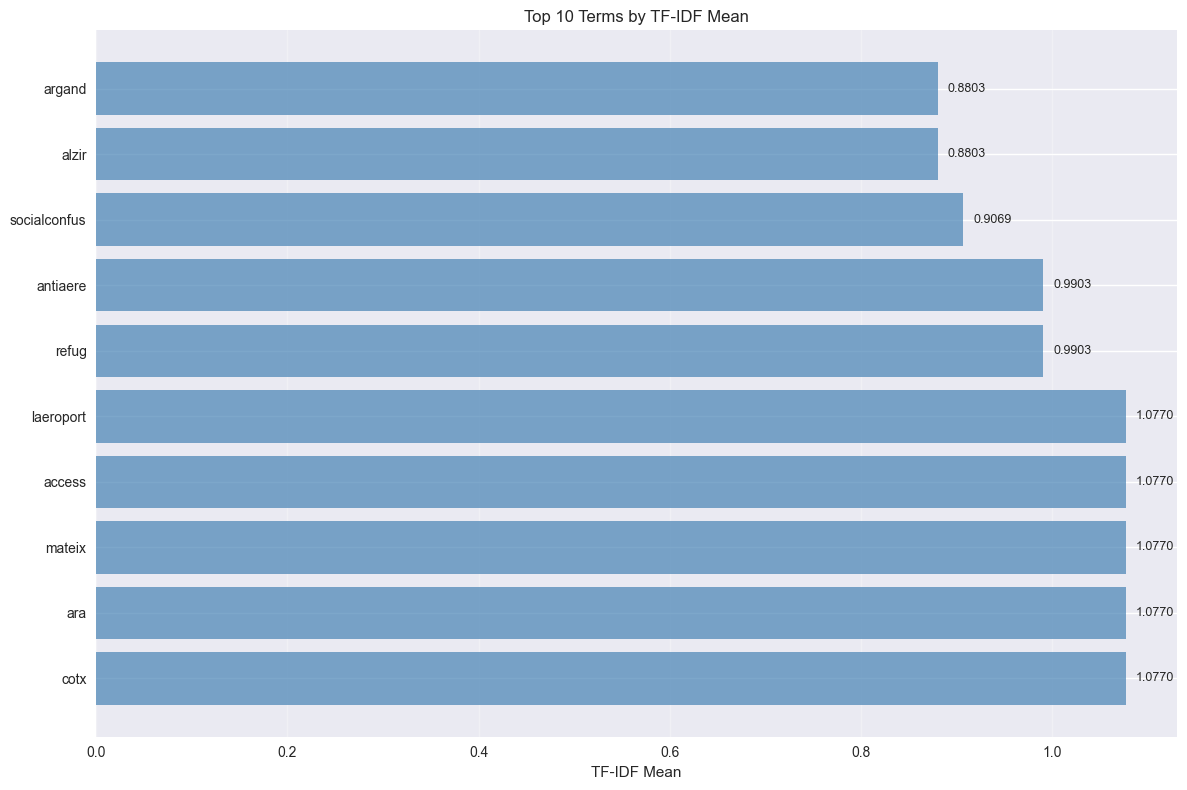

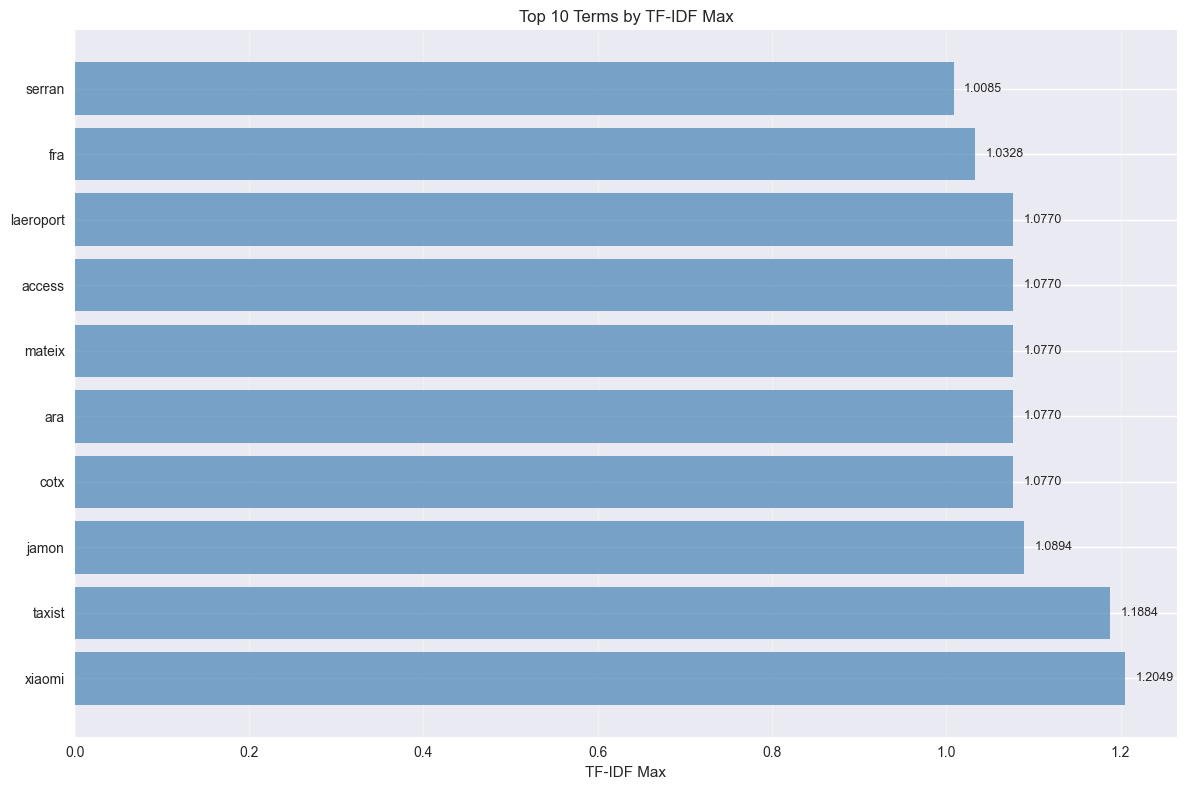

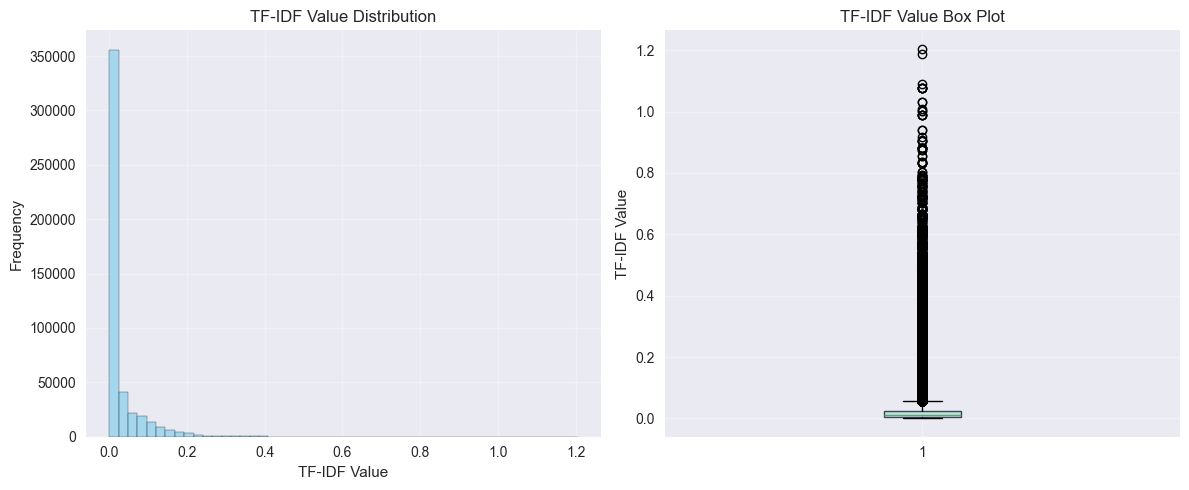

In [37]:
class TFIDFVisualizer:

    
    def __init__(self, analyzer: TFIDFAnalyzer):
        self.analyzer = analyzer
    
    def plot_term_distribution(self, metric: str = 'mean', top_n: int = 15):
        top_terms = self.analyzer.get_top_terms_by_metric(metric, top_n)
        
        if not top_terms:
            return
        
        terms = [term for term, _ in top_terms]
        values = [stats[metric] for _, stats in top_terms]
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(terms)), values, color='steelblue', alpha=0.7)
        
        plt.yticks(range(len(terms)), terms)
        plt.xlabel(f'TF-IDF {metric.title()}')
        plt.title(f'Top {top_n} Terms by TF-IDF {metric.title()}')
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_width() + max(values) * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{value:.4f}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    def plot_tfidf_distribution(self):
        all_values = []
        for doc_tfidf in self.analyzer.tfidf_matrix:
            all_values.extend(doc_tfidf.values())
        
        if not all_values:
            return
        
        plt.figure(figsize=(12, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(all_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('TF-IDF Value')
        plt.ylabel('Frequency')
        plt.title('TF-IDF Value Distribution')
        plt.grid(alpha=0.3)
        
        # Box plot
        plt.subplot(1, 2, 2)
        plt.boxplot(all_values, patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
        plt.ylabel('TF-IDF Value')
        plt.title('TF-IDF Value Box Plot')
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_comprehensive_analysis(self):
        print("TF-IDF Comprehensive Analysis")
        print("=" * 40)
        
        # Plot term distributions
        self.plot_term_distribution('mean', 10)
        self.plot_term_distribution('max', 10)
        
        # Plot overall distribution
        self.plot_tfidf_distribution()

# Create visualizations
if 'analyzer' in locals() and analyzer.term_statistics:
    visualizer = TFIDFVisualizer(analyzer)
    visualizer.create_comprehensive_analysis()


In [39]:
class TFIDFDataExporter:
    
    def __init__(self, analyzer: TFIDFAnalyzer, tfidf_matrix: List[Dict[str, float]]):
        self.analyzer = analyzer
        self.tfidf_matrix = tfidf_matrix
    
    def create_tfidf_dataframe(self) -> pd.DataFrame:
        tfidf_records = []
        
        for doc_idx, doc_tfidf in enumerate(self.tfidf_matrix):
            for term, tfidf_value in doc_tfidf.items():
                tfidf_records.append({
                    'document_id': doc_idx,
                    'term': term,
                    'tfidf_score': tfidf_value
                })
        
        return pd.DataFrame(tfidf_records)
    
    def create_term_statistics_dataframe(self) -> pd.DataFrame:
        stats_records = []
        
        for term, statistics in self.analyzer.term_statistics.items():
            record = {'term': term}
            record.update(statistics)
            stats_records.append(record)
        
        return pd.DataFrame(stats_records)
    
    def export_results(self, output_dir: pathlib.Path) -> Dict[str, pathlib.Path]:
        output_paths = {}
        

        tfidf_df = self.create_tfidf_dataframe()
        tfidf_path = output_dir / 'tfidf_scores_matrix.csv'
        tfidf_df.to_csv(tfidf_path, index=False, encoding='utf-8')
        output_paths['tfidf_matrix'] = tfidf_path

        stats_df = self.create_term_statistics_dataframe()
        stats_path = output_dir / 'term_statistics_summary.csv'
        stats_df.to_csv(stats_path, index=False, encoding='utf-8')
        output_paths['term_statistics'] = stats_path
        

        metrics = ['mean', 'max', 'document_count']
        for metric in metrics:
            top_terms = self.analyzer.get_top_terms_by_metric(metric, 100)
            top_terms_df = pd.DataFrame(
                [(term, stats[metric], stats['document_count']) 
                 for term, stats in top_terms],
                columns=['term', f'{metric}_score', 'document_count']
            )
            
            metric_path = output_dir / f'top_terms_by_{metric}.csv'
            top_terms_df.to_csv(metric_path, index=False, encoding='utf-8')
            output_paths[f'top_terms_{metric}'] = metric_path
        
        return output_paths
    
    def generate_analysis_report(self, output_dir: pathlib.Path) -> pathlib.Path:
        report_path = output_dir / 'tfidf_analysis_report.txt'
        summary_stats = self.analyzer.get_summary_statistics()
        
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("TF-IDF FEATURE WEIGHTING ANALYSIS REPORT\n")
            f.write("=" * 50 + "\n\n")
            
            # Summary statistics
            f.write("SUMMARY STATISTICS\n")
            f.write("-" * 20 + "\n")
            for stat_name, value in summary_stats.items():
                if isinstance(value, float):
                    f.write(f"{stat_name.replace('_', ' ').title()}: {value:.6f}\n")
                else:
                    f.write(f"{stat_name.replace('_', ' ').title()}: {value:,}\n")
            
            # Top terms analysis
            f.write(f"\nTOP TERMS ANALYSIS\n")
            f.write("-" * 20 + "\n")
            
            metrics = ['mean', 'max', 'document_count']
            for metric in metrics:
                top_terms = self.analyzer.get_top_terms_by_metric(metric, 10)
                f.write(f"\nTop 10 terms by {metric.replace('_', ' ').title()}:\n")
                
                for i, (term, stats) in enumerate(top_terms, 1):
                    value = stats[metric]
                    docs = stats['document_count']
                    f.write(f"  {i:2d}. {term:<20} | {metric.title()}: {value:.6f} | Docs: {docs:4d}\n")
            
            f.write(f"\nReport generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        return report_path

# Export analysis results
if 'analyzer' in locals() and 'tfidf_matrix' in locals():
    exporter = TFIDFDataExporter(analyzer, tfidf_matrix)
    
 
    tfidf_dataframe = exporter.create_tfidf_dataframe()
    term_stats_dataframe = exporter.create_term_statistics_dataframe()
    
    # Display summary
    print("TF-IDF Analysis Results Summary:")
    print("=" * 35)
    print(f"Total term-document entries: {len(tfidf_dataframe):,}")
    print(f"Unique terms analyzed: {len(term_stats_dataframe):,}")
    print(f"Average TF-IDF score: {tfidf_dataframe['tfidf_score'].mean():.6f}")
    print(f"Maximum TF-IDF score: {tfidf_dataframe['tfidf_score'].max():.6f}")
    

    exported_files = exporter.export_results(OUTPUT_DIR)
    report_file = exporter.generate_analysis_report(OUTPUT_DIR)
    
    print(f"\nResults exported to: {OUTPUT_DIR}")
    print("Generated files:")
    for file_type, file_path in exported_files.items():
        print(f"  - {file_type}: {file_path.name}")
    print(f"  - analysis_report: {report_file.name}")
    

    print(f"\nSample TF-IDF Results:")
    display(tfidf_dataframe.head())

TF-IDF Analysis Results Summary:
Total term-document entries: 478,949
Unique terms analyzed: 22,363
Average TF-IDF score: 0.029760
Maximum TF-IDF score: 1.204913

Results exported to: C:\Users\ABRAHAM\Documents\GitHub\Practica-1\data\ponderacion_caracteristicas
Generated files:
  - tfidf_matrix: tfidf_scores_matrix.csv
  - term_statistics: term_statistics_summary.csv
  - top_terms_mean: top_terms_by_mean.csv
  - top_terms_max: top_terms_by_max.csv
  - top_terms_document_count: top_terms_by_document_count.csv
  - analysis_report: tfidf_analysis_report.txt

Sample TF-IDF Results:

Results exported to: C:\Users\ABRAHAM\Documents\GitHub\Practica-1\data\ponderacion_caracteristicas
Generated files:
  - tfidf_matrix: tfidf_scores_matrix.csv
  - term_statistics: term_statistics_summary.csv
  - top_terms_mean: top_terms_by_mean.csv
  - top_terms_max: top_terms_by_max.csv
  - top_terms_document_count: top_terms_by_document_count.csv
  - analysis_report: tfidf_analysis_report.txt

Sample TF-IDF R

,document_id,term,tfidf_score
0,0,distint,0.168898
1,0,desinform,0.251598
2,0,senal,0.113962
3,0,fals,0.178123
4,0,la,0.014394


## Resumen del Análisis TF-IDF

### Resultados Obtenidos:
- **Documentos procesados**: 5,518 textos de noticias en español
- **Vocabulario total**: 22,363 términos únicos
- **Entradas TF-IDF**: 478,949 puntuaciones de términos-documentos
- **Score TF-IDF promedio**: 0.0298
- **Score TF-IDF máximo**: 1.205

### Términos más Relevantes:
1. **Por puntuación promedio**: Términos raros con alta especificidad (cotx, ara, mateix, access, laeroport)
2. **Por puntuación máxima**: Términos con alta importancia en documentos específicos (xiaomi, taxist, jamon)
3. **Por frecuencia de documentos**: Palabras comunes del español (de, la, el, en, que)

### Archivos Generados:
- `tfidf_scores_matrix.csv`: Matriz completa de puntuaciones TF-IDF
- `term_statistics_summary.csv`: Estadísticas de términos
- `top_terms_by_*.csv`: Rankings de términos por diferentes métricas
- `tfidf_analysis_report.txt`: Reporte completo del análisis

El análisis TF-IDF proporciona una base sólida para la identificación de características importantes en textos de noticias para tareas de clasificación automática.